# StampNet analysis notebook
TL;DR 
1. Run all cells
2. Wait around 30 seconds.
3. Figures and measures of the [paper](https://arxiv.org/pdf/1902.02693.pdf) are at gathered the end.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
import os
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pprint
import glob
import imp
import seaborn as sns
from itertools import zip_longest
import matplotlib.colors as colors
from matplotlib import gridspec

# Setting up GPU environment
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Loading the dataset and model 
### Hyperparameters

In [2]:
# Retrieve the experiment data.
# Different possible filenames:
#   simple_shapes_2
#   t_minst_1 (no experiment 0)
#   t_mnist_2
#   ct_mnist_1
#   ct_mnist_2
#   pedestrian
experiment_file = "ct_mnist_2"

# Number 0 contains the weights of the StampNet paper.
experiment_nr = 0

##### TEST HYPERPARAMETERS #####
# Make the gumbel softmax like a softmax.
tau_test_value = 0.0001 
ipy_seed = 42

# File containing the StampNet model.
model_file = "stamp_network"

# Load (a list of) specific weights in the model.
# For example: custom_weight_epochs = [10, 800]
# Or: [800]
custom_weight_epochs = False

### Loading parameters

In [3]:
### Loading the experiment files.
exp_prefix = os.path.join("runs", experiment_file, str(experiment_nr))
config_file = os.path.join(exp_prefix, "config.json")
run_file = os.path.join(exp_prefix, "run.json")
out_file = os.path.join(exp_prefix, "cout.txt")

# Load the experiment configuration parameters.
with open(config_file) as cf:
    config_params = json.load(cf)

# Load the run parameters.
with open(run_file) as rf:
    run_params = json.load(rf)
    
# Retrieving the source file as noted in the config file
for source_file, snapshot in run_params["experiment"]["sources"]:
    if model_file in source_file or experiment_file in source_file:
        source_path = os.path.join(exp_prefix, "..", snapshot)
        sac = imp.load_source(source_file, source_path)
        
weights_folder = os.path.join(exp_prefix, "trained", "")
model_folder = os.path.join(exp_prefix, "model", "")

run_parameters = config_params["run_parameters"]
layer_parameters = config_params["layer_parameters"]
decoder_parameters = layer_parameters["decoder_parameters"]
encoder_parameters = layer_parameters["encoder_parameters"]
input_parameters = layer_parameters["input_parameters"]


nr_of_stamps = decoder_parameters["nr_of_stamps"]
stamps_per_canvas = decoder_parameters["stamps_per_canvas"]
img_type_parameters = run_parameters["img_type_parameters"]

img_type = run_parameters["img_type"]
img_rows = input_parameters["img_rows"]
img_cols = input_parameters["img_cols"]

run_seed = config_params["seed"]

show_parameters = False
if show_parameters:
    pp = pprint.PrettyPrinter(indent=2)
    pp.pprint(config_params)

### Loading the model

In [4]:
import keras.backend as K

# Setting gumbel parameters according to the tau test value.
layer_parameters["decoder_parameters"]["gumbel_parameters"]["min_temperature"] = tau_test_value
layer_parameters["decoder_parameters"]["gumbel_parameters"]["tau_init"] = tau_test_value

model = sac.model.__wrapped__(layer_parameters, random_seed=run_seed, compile=False)

show_model = False
if show_model:
    model.summary()

print()
print("Model succesfully loaded!")

/home/joost/.virtualenvs/stampnet/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1e-04> tau
tracking <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0> sample_sum
tracking <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0> epoch_nr
tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1e-04> tau
tracking <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0> sample_sum
tracking <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0> epoch_nr
tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1e-04> tau
tracking <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0> sample_sum
tracking <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0> epoch_nr

Model succesfully loaded!


### Loading weights

In [5]:
def get_weight_nr(file_name):
    return int(file_name.split('weights.')[1].split('-')[0])

def retrieve_weights(weight_list=False):
    """
    Load the weights in the experiment folder. 
    Sample parameter:
      weight_list = [100, 200, 400, 800]
    """
    file_names = glob.glob(weights_folder + '*hdf5')

    if custom_weight_epochs:
        weight_files = [(i, get_weight_nr(i)) for i in file_names if get_weight_nr(i) in weight_list]
        weight_files_sorted = sorted(weight_files, key=lambda x: x[1])
    else:
        weight_files = [(i, get_weight_nr(i)) for i in file_names]
        weight_files_sorted = [sorted(weight_files, key=lambda x: x[1])[-1]]
    return weight_files_sorted

In [6]:
weight_files_sorted = retrieve_weights(custom_weight_epochs)

model.load_weights(weight_files_sorted[-1][0])
print("Model succesfully loaded!")

Model succesfully loaded!


### Loading testset

In [7]:
from utils.seed_util import retrieve_random_state as rrs
import utils.img_gen as ig


def retrieve_data(img_rows, img_type, img_type_parameters, random_seed):
    """
    Retrieve the test set and the coordinates depending on the image type.
    For the pedestrian, y_test is None and will be inferred later for the
      purity measure.
    """
    r = rrs(random_seed)
    if img_type == "t_shape":
        (_, _), (x_test, y_test), (_, x_test_coords) = ig.get_localized_images(
            canvas_size=img_rows,
            img_type=img_type,
            shapes_to_use=img_type_parameters["shapes_to_use"],
            shape_size=img_type_parameters["shape_size"],
            nr_img_per_canvas=img_type_parameters["nr_img_per_canvas"],
            overlap=img_type_parameters["overlap"],
            test_only=True,
            random_seed=r.randint(1e9))
    elif img_type == 't_mnist':
         (_, _), (x_test, y_test), (_, x_test_coords) = ig.get_localized_images(
            canvas_size=img_rows,
            img_type=img_type,
            nr_img_per_canvas=img_type_parameters["nr_img_per_canvas"],
            overlap=img_type_parameters['overlap'],
            test_only=True,
            random_seed=r.randint(1e9))

    elif img_type == "ct_mnist":
         (_, _), (x_test, y_test), (_, x_test_coords) = ig.get_cluttered_mnist(
            img_type_parameters["data_path"], 
            test_only=True,
            random_seed=r.randint(1e9))

    elif img_type == 'pedestrian':
        (_, _), (x_test, y_test), (_, x_test_coords) = ig.get_ped_data(
            data_path=img_type_parameters["data_path"],
            shuffle=img_type_parameters["shuffle"],
            random_seed=r.randint(1e9))
    else:
        raise ValueError(f"Image type '{img_type}' not supported.")
        
    return (x_test, y_test, x_test_coords)

In [8]:
x_test, y_test, x_test_coords = \
  retrieve_data(img_rows=input_parameters["img_rows"], 
                img_type=run_parameters["img_type"], 
                img_type_parameters=img_type_parameters, 
                random_seed=ipy_seed)


x_test = x_test[:,:,:,None] # Add an extra dimension
x_test = x_test.astype('float32')

print("Test data loaded!")


Test data loaded!


## Testing
### Useful figure variables and function

In [9]:
def save_image(file_path):
    print("Saving figure...")
    margins(0,0)
    gca().xaxis.set_major_locator(NullLocator())
    gca().yaxis.set_major_locator(NullLocator())
    savefig(file_path, bbox_inches="tight", pad_inches=0)
    
vmin = 0.0
vmax = np.max(x_test)
orange = '#ffc006'
darkblue = '#002cae'

### Retrieving results (forward propagation)

In [10]:
def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

def predict_output(model):
    """
    Forward propagation.
    The model has three outputs:
      - Direct reconstruction output
      - 2D-tensor with coordinate prediction
      - 1D-tensor with stampnet prediction
    """
    batch_size = input_parameters["batch_size"]
    # Casting the test set into batches of 64 and have some fill values, then predict using keras.
    predictions = [model.predict(np.array(x), batch_size=batch_size) 
                       for x in grouper(batch_size, x_test, np.ones([x_test.shape[1], x_test.shape[2], 1]))]

    # Cast the outputs into a usable array
    flatten = lambda l: [item for sublist in l for item in sublist]
    outputs = np.array(flatten([x[0] for x in predictions])[:len(x_test)])
    stamp_distr = np.array(flatten([x[1] for x in predictions])[:len(x_test)])
    coord_distr = np.array(flatten([x[2] for x in predictions])[:len(x_test)])
    nr_outputs = len(predictions[0])

    output_dict = {
        "outputs": outputs, 
        "stamp_distr": stamp_distr, 
        "coord_distr": coord_distr
    }

    return output_dict

weight_file, epoch = weight_files_sorted[-1]
print("Predicting for epoch: " + str(epoch))

# Calculate the predictions.
model.load_weights(weight_file)
stamps = model.get_layer('stamp_layer')
stamp_weights = stamps.get_weights()[0]

output_dict = predict_output(model)

outputs = output_dict["outputs"]
stamp_distr = output_dict["stamp_distr"]
coord_distr = output_dict["coord_distr"]

Predicting for epoch: 1000


### Plotting the kernel of the stamp layer

In [11]:
def plot_stamps():
    plt.figure(figsize = (7.5,3))

    for idx in range(nr_of_stamps):
        plt.subplot(ceil(nr_of_stamps / 10.0), min(nr_of_stamps,10), idx+1)
        plt.axis("off")
        imshow(stamp_weights[::-1,::-1,idx,0])

### Input, reconstruction and predicted bounding boxes

In [12]:
# Functions for drawing the bounding boxes.
def draw_bounding_box(canvas, coord, shape_size=28, bounding_box_value=2.0):
    """
    Drawing the bounding box with coord as upper-left coordinate
      and the size of shape_size with value bounding_box_value.
    """
    ss = shape_size
    
    y_min = max(coord[0], 0)
    y_max = min(coord[0] + ss, canvas.shape[0])
    x_min = max(coord[1], 0)
    x_max = min(coord[1] + ss, canvas.shape[1])
    
    
    # Horizontal lines of the box
    canvas[y_min:y_max, x_min] = bounding_box_value
    canvas[y_min:y_max, x_max - 1] = bounding_box_value
    
    # Veritcal lines of the box
    canvas[y_min, x_min:x_max] = bounding_box_value
    canvas[y_max - 1, x_min:x_max] = bounding_box_value

    return canvas

def get_canvas_box(i, bounding_box_value=2.0, stamp_size=28):
    """
    Returns the predicted bounding boxes.
    """
    canvas_box = np.zeros(shape=(img_rows, img_cols))

    for s in range(stamps_per_canvas):
        canvas_coord = coord_distr[i,s,:,:]
        coord = np.unravel_index(np.argmax(canvas_coord), canvas_coord.shape)
        canvas_box = draw_bounding_box(canvas_box, coord, stamp_size, bounding_box_value)

    canvas_box = np.maximum(canvas_box, -1.0)
    return canvas_box

def get_true_box(image_nr, bounding_box_value=2.0, stamp_size=28):
    """
    Returns the labelled bounding boxes (calculated from the coordinate labels).
    """
    shape_size = stamp_size
    
    canvas_box = np.zeros(shape=(img_rows, img_cols))
    canvas_box = draw_bounding_box(canvas_box, x_test_coords[image_nr], shape_size, bounding_box_value)
    
    return canvas_box

def draw_input_bounding_box_output(selected_images):
    # Figure variables, in order to make it look fancy.
    img_rows = input_parameters["img_rows"]
    img_cols = input_parameters["img_cols"]
    stamp_size = decoder_parameters['stamp_size']

    nr_cols = 7
    nr_rows = (len(selected_images) + 1) // 2 * 2 - 1

    plt.figure(figsize=(nr_cols+6, 1.6 + 3.2*(nr_rows) // 2))
    gs = gridspec.GridSpec(nr_rows, 
                           nr_cols,
                           width_ratios=nr_cols//2 * [1] + [0.15] + nr_cols//2 * [1],
                           height_ratios=(nr_rows // 2) * [1, 0.2] + [1])

    cmap_list = ["white","grey", orange]

    if img_type == "pedestrian":
        cmap_list.append(darkblue)

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cmap_list)

    # Plotting the images.
    c = 0
    for idx in selected_images:
        ### Plotting input
        plt.subplot(gs[c])    
        plt.title("Input", fontsize=18)
        plt.axis("off")

        input_image = x_test[idx,:,:,0]
        imshow(input_image, cmap='viridis', vmin=vmin, vmax=vmax)
        c += 1


        ### Plotting predicted bounding box
        plt.subplot(gs[c])
        plt.title("Bounding\nbox", fontsize=18)
        plt.axis("off")

        canvas_box = get_canvas_box(idx, stamp_size=stamp_size)

        if img_type == "pedestrian":
            true_box = get_true_box(idx, 3.0, stamp_size=stamp_size)
            true_box_input = np.minimum(true_box + x_test[idx,:,:,0], 3.0)
            bounding_box_to_plot = np.maximum(true_box_input, canvas_box)
        else: 
            canvas_box_input = np.minimum(canvas_box + x_test[idx,:,:,0], 2.0)
            bounding_box_to_plot = canvas_box_input

        imshow(bounding_box_to_plot, cmap=cmap)
        c += 1

        ## Plotting prediction
        plt.subplot(gs[c])
        plt.title("Prediction", fontsize=18)
        plt.axis("off")

        pred_image = outputs[idx,:,:,0]
        imshow(pred_image, cmap='viridis', vmin=vmin, vmax=vmax)

        # White space between images.
        if c % nr_cols == 2:
            c += 2
        elif c % (2*nr_cols) == (nr_cols - 1):
            c += 8
        else:
            c += 1

## Statistics
### Functions for calculating the statistics

In [13]:
from sklearn.metrics import normalized_mutual_info_score
from utils.extra_util import get_accuracy

##### Constants
eps = 1e-5
nr_samples = x_test.shape[0]

##### Specific measures

def manhattan_distance(coord_a, coord_b):
    return abs(coord_a[0] - coord_b[0]) + abs(coord_a[1] - coord_b[1])

def binary_crossentropy(y, y_hat):
    bce = -np.mean(np.sum(y*np.log2(y_hat + eps) + \
                          (1-y)*np.log2((1-y_hat)+ eps), axis=(-1, -2)))
    return bce

def calc_purity(confuse_matrix, nr_of_samples):
    return np.sum(np.max(confuse_matrix, axis=0)) / float(nr_of_samples)

def calc_iou(true_c, pred_c):
    """
    Calculate the IoU measure.
    """
    intersection = np.sum(np.minimum(true_c, pred_c))
    union = np.sum(np.maximum(true_c, pred_c))
    return intersection / union


##### Retrieve predicted coordinates and stamps from softmax. 

def get_coord(coord_distr, i, s):
    canvas_coord = coord_distr[i,s,:,:]
    coord = np.unravel_index(np.argmax(canvas_coord), canvas_coord.shape)
    return coord

def get_coords_list(coord_distr):
    coords_list = np.empty((nr_samples, stamps_per_canvas, 2), dtype='int16')
    for i in range(nr_samples):
        for s in range(stamps_per_canvas):
            coords_list[i,s] = get_coord(coord_distr, i, s)
    return coords_list

def get_stamps_list(stamp_distr):
    return np.argmax(stamp_distr, axis=-1)

##### Functions for calculating statistics for StampNet.

def assign_stamp_to_labels(outputs, stamps_list, coords_list):
    """
    Assigns which stamp belongs to which output for calculating the measures.
    The assignment happens greedily from small to large.
    We also keeps track of the statistic of how many each stamp is used.
    
    stamp_to_label[i,s]: 
    For sample i, the s'th stamp predicts label stamp_to_label[i,s]
    
    stamp_idx_to_label_idx[i,s]:
    For sample i, the s'th stamp is assigned to label idx
       stamp_idx_to_label_idx[i,s]
    
    For the pedestrian dataset, we only assign the pedestrian as a (1) 
      and the rest as a (0). This is equivalent to the test-set.
    """
    stamp_usages = pd.DataFrame()
    stamp_usages['usage_total'] = nr_of_stamps*[0]
    
    for i in range(stamps_per_canvas):
        stamp_usages['usage_' + str(i)] = nr_of_stamps*[0] 
    
    stamp_idx_to_label_idx = []
    stamp_to_label = []
    
    for i in range(nr_samples):
        predicted_stamps = stamps_list[i]
        predicted_stamps_permuted = np.zeros_like(predicted_stamps)
        
        for s, predicted_stamp in enumerate(predicted_stamps):
            stamp_usages.loc[predicted_stamp, 'usage_total'] += 1
            stamp_usages.loc[predicted_stamp, 'usage_'+str(s)] += 1
                
        test_coords = x_test_coords[i]
        
        # For all but the pedestrian dataset, we greedily assign each stamp 
        #   to the closest label. 
        #   (An alternative would be to minimize the total distance.)
        #
        # For the pedestrian dataset, we only assign the stamp that is the 
        #   closest to the pedestrian as a pedestrian (1) as we only have 
        #   the coordinates of the pedestrian. The rest is assigned a (0).
        # This is both useful as a test-set for calculating the purity w.r.t. 
        #   the stamp and as a one-hot-encoding for the stamp selected.
        if img_type == "pedestrian":
            test_coord = test_coords
            
            diff_list = []
            for s in range(stamps_per_canvas):
                diff = manhattan_distance(coords_list[i,s], test_coord)
                diff_list.append(diff)
                
            preferred_stamp_idx = np.argmin(diff_list)
            
            cur_stamp_idx_to_label_idx = np.zeros(stamps_per_canvas, 'uint8')
            cur_stamp_idx_to_label_idx[preferred_stamp_idx] = 1
            
            stamp_idx_to_label_idx.append(cur_stamp_idx_to_label_idx)
            stamp_to_label.append(predicted_stamps)
            
        else:
            # Using a greedy O(n^2) algorithm to decide the closest coord.
            if stamps_per_canvas == 1:
                stamp_to_label.append(predicted_stamps)
            else:
                cur_stamp_idx_to_label_idx = []
                taken_stamps = set()
                for test_coord, predicted_stamp in zip(test_coords, predicted_stamps):
                    diff_list = []
                    for s in range(stamps_per_canvas):
                        diff = manhattan_distance(coords_list[i, s], test_coord)
                        diff_list.append(diff)

                    while(True):
                        preferred_stamp_idx = np.argmin(diff_list)

                        if preferred_stamp_idx not in taken_stamps:
                            break;
                        else:
                            diff_list[preferred_stamp_idx] = 999
                                
                    taken_stamps.add(preferred_stamp_idx)
        
                    cur_stamp_idx_to_label_idx.append(preferred_stamp_idx)
        
                    predicted_stamps_permuted[preferred_stamp_idx] = predicted_stamp
            
                stamp_to_label.append(predicted_stamps_permuted)
                stamp_idx_to_label_idx.append(cur_stamp_idx_to_label_idx)
                
    return np.array(stamp_to_label), np.array(stamp_idx_to_label_idx), stamp_usages

def fill_coord(canvas, coord, stamp_size):
    """
    Puts a 1 at the area where the stamp is.
    This is used to calculate the IoU.
    """
    new_canvas = np.copy(canvas)
    
    ss = stamp_size

    y_min = max(coord[0], 0)
    y_max = min(coord[0] + ss, new_canvas.shape[0])
    x_min = max(coord[1], 0)
    x_max = min(coord[1] + ss, new_canvas.shape[1])

    new_canvas[y_min:y_max, x_min:x_max] = 1
    
    return new_canvas

def iou_corloc_from_coords(true_coords, 
                           pred_coords, 
                           stamp_idx_to_label_idx=False, 
                           stamp_size=28):
    """
    Calculate the IoU using the coordinates and stamp/shape sizes.
    We recursively fill two canvases, one with the location of the shapes
      and another one with the predicted locations. These are used for the
      Intersect over Union calculation.
    """
    iou_list = []
    cor_loc_list = []
    
    for i in range(nr_samples):
        empty_canvas = np.zeros(shape=(input_parameters["img_rows"], 
                                       input_parameters["img_cols"]))
        
        true_canvas = np.copy(empty_canvas)
        pred_canvas = np.copy(empty_canvas)

        if stamps_per_canvas == 1 or img_type == 'pedestrian':
            true_canvas = fill_coord(true_canvas, np.squeeze(true_coords[i]), stamp_size)
            pred_canvas = fill_coord(pred_canvas, np.squeeze(pred_coords[i]), stamp_size)
            cur_iou = calc_iou(true_canvas, pred_canvas)
            cor_locs = [cur_iou >= 0.5]
        else:
            cor_locs = []

            for j in range(stamps_per_canvas):
                true_canvas = fill_coord(true_canvas, true_coords[i,j], stamp_size)
                pred_canvas = fill_coord(pred_canvas, pred_coords[i,j], stamp_size)

                # Calculate whether IoU is > 0.5 for c
                true_cur_canvas = fill_coord(empty_canvas, true_coords[i,stamp_idx_to_label_idx[i][j]], stamp_size)
                pred_cur_canvas = fill_coord(empty_canvas, pred_coords[i,j], stamp_size)
                cur_iou = calc_iou(true_cur_canvas, pred_cur_canvas)
                cor_locs.append(cur_iou >= 0.5)

        iou = calc_iou(true_canvas, pred_canvas)
        iou_list.append(iou)
        cor_loc_list.append(cor_locs)
        
    return np.mean(iou_list), np.mean(cor_loc_list)

def get_statistics(outputs,
                   stamps_list,
                   coords_list,
                   x_test,
                   y_test):
    """
    Calculating various performance statistics for StampNet.
    """
    # Assigns stamps to their respective labels (using indexes).
    stamp_to_label, stamp_idx_to_label_idx, stamp_usages = \
        assign_stamp_to_labels(outputs, stamps_list, coords_list)
    
    # We can use this trick to set the y_test,
    #   because only our pedestrian-assigned stamp = 1, while the others are 0.
    if img_type == "pedestrian":
        y_test = stamp_idx_to_label_idx
    
    avg_total_mse = np.mean(np.mean((outputs[:,:,:,0] - x_test[:,:,:,0])**2))
    avg_total_bce = binary_crossentropy(x_test[:,:,:,0], outputs[:,:,:,0])

    nmi = normalized_mutual_info_score(stamp_to_label.flatten(), y_test.flatten())
    acc, confuse_matrix = \
        get_accuracy(stamp_to_label.flatten(), y_test.flatten(), nr_of_stamps)

    # Remove empty true classes from the confuse matrix.
    confuse_matrix = confuse_matrix[:len(set(y_test.flatten())),:]

    purity = calc_purity(confuse_matrix, len(y_test.flatten()))

    avg_entropy = 0

    mean_entropy_stamp_distr = \
        np.mean(-np.sum(stamp_distr * np.log2(stamp_distr + eps), axis=2))
    max_entropy_stamp_distr = \
        np.max(-np.sum(stamp_distr * np.log2(stamp_distr + eps), axis=2))

    mean_entropy_coord_distr = \
        np.mean(-np.sum(coord_distr * np.log2(coord_distr + eps), axis=2))
    max_entropy_coord_distr = \
        np.max(-np.sum(coord_distr * np.log2(coord_distr + eps), axis=2))
    
    # Grab only the coordinates of the stamps who are predicted to be
    #   a pedestrian, i.e. index where y_test[i] == 1
    if img_type == "pedestrian":
        coords_list = np.array([coords_list[i, np.argmax(y_test[i], axis=-1)] 
                                    for i in range(nr_samples)])

    iou, cor_loc = \
        iou_corloc_from_coords(x_test_coords, coords_list, stamp_idx_to_label_idx)
    
    statistics = {
        'avg_total_mse': avg_total_mse,
        'avg_total_bce': avg_total_bce,
        'nmi': nmi,
        'acc': acc,
        'purity': purity,
        'mean_entropy_stamp_distr': mean_entropy_stamp_distr,
        'max_entropy_stamp_distr': max_entropy_stamp_distr,
        'mean_entropy_coord_distr': mean_entropy_coord_distr,
        'max_entropy_coord_distr': max_entropy_coord_distr,
        'iou': iou,
        'cor_loc': cor_loc
    }
    
    return statistics, stamp_usages

In [14]:
def calc_all_statistics():
    # Gather statistics for all weights in weight_files_sorted
    all_stats = []
    for weight_file, idx in reversed(weight_files_sorted):
        print("Predicting for epoch: " + str(idx))
        model.load_weights(weight_file)
        output_dict = predict_output(model)

        outputs = output_dict["outputs"]
        stamps_list = get_stamps_list(output_dict["stamp_distr"])
        coords_list = get_coords_list(output_dict["coord_distr"])

        statistics, stamp_usages = get_statistics(outputs,
                                                  stamps_list,
                                                  coords_list,
                                                  x_test,
                                                  y_test)

        df = pd.DataFrame(statistics, index=[idx])
        df.columns.name="epoch"
        all_stats.append(df)

    all_stats_df = pd.concat(all_stats)
    return all_stats_df

# Paper contents
### Paper figures

In [15]:
save_figs=False

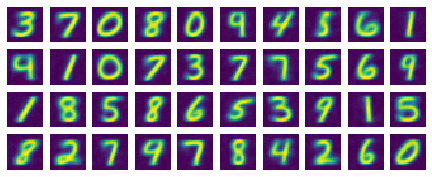

In [16]:
plot_stamps()
if save_figs:
    save_image("figs/ped-new-28-stamps.pdf")

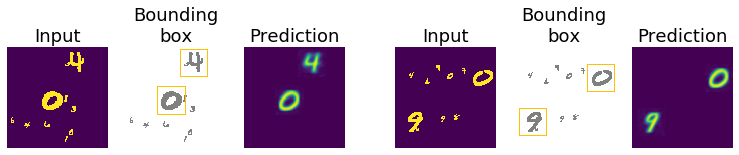

In [19]:
draw_input_bounding_box_output(selected_images=[0, 5])
if save_figs:
    save_image("figs/ped-new-28-outputs.pdf")

### Paper measures

In [18]:
all_stats_df = calc_all_statistics()
all_stats_df[["avg_total_mse", "iou", "purity", "cor_loc"]]

Predicting for epoch: 1000


/home/joost/.virtualenvs/stampnet/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


epoch,avg_total_mse,iou,purity,cor_loc
1000,0.025677,0.838237,0.6063,0.95365
